In [1]:
import sys
sys.path.append("../../src")
sys.path.append("..")

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from utils.kernel_utils import RBF, ColumnwiseRBF
from causal_models.causal_learning import KernelATE
from AlternativeProxyKernel.generate_experiment_data import generate_synthetic_data

from jax import config
config.update("jax_enable_x64", True)

In [2]:
data_size = 1000
seed = 47
np.random.seed(seed)

U, W, Z, A, Y, do_A, EY_do_A = generate_synthetic_data(size = data_size, seed = seed)

W, Z, A, Y, do_A, EY_do_A = jnp.array(W), jnp.array(Z), jnp.array(A), jnp.array(Y), jnp.array(do_A), jnp.array(EY_do_A)

train_data_perc = 1.0
test_data_perc = 1 - train_data_perc

indices = np.random.permutation(A.shape[0])
train_data_size = int(A.shape[0] * train_data_perc)
training_idx, test_idx = indices[:train_data_size], indices[train_data_size:]

A_train, Y_train, W_train, Z_train, U_train = A[training_idx], Y[training_idx], W[training_idx], Z[training_idx], U[training_idx]
U_train = np.c_[W_train, Z_train, U_train]

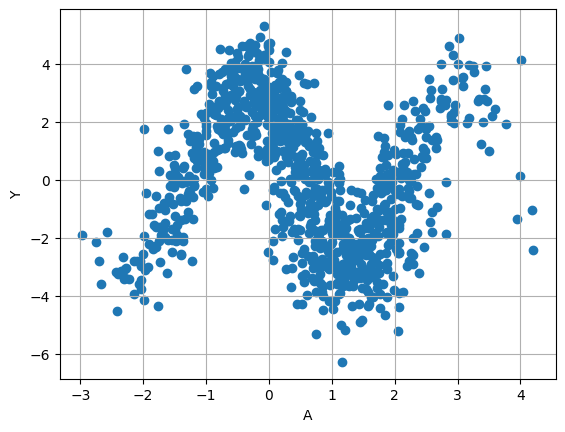

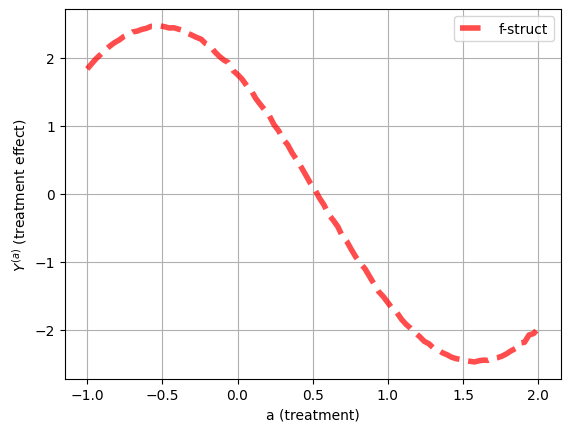

In [3]:
plt.scatter(A, Y)
plt.xlabel("A")
plt.ylabel("Y")
plt.grid()
plt.show()


plt.plot(do_A, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.show()

In [4]:
kernel_X = RBF(use_median_length_scale_heuristic = True, use_jit_call = True)
kernel_A = RBF(use_median_length_scale_heuristic = True)
optimize_regularization_parameters = True
lambda_optimization_range = (1e-9, 1.0)
regularization_grid_points = 150

KernelATE_model = KernelATE(kernel_X = kernel_X,
                            kernel_A = kernel_A, 
                            optimize_regularization_parameters = optimize_regularization_parameters, 
                            lambda_optimization_range = lambda_optimization_range, 
                            regularization_grid_points = regularization_grid_points)

In [5]:
KernelATE_model.fit((A_train, U_train), Y_train)

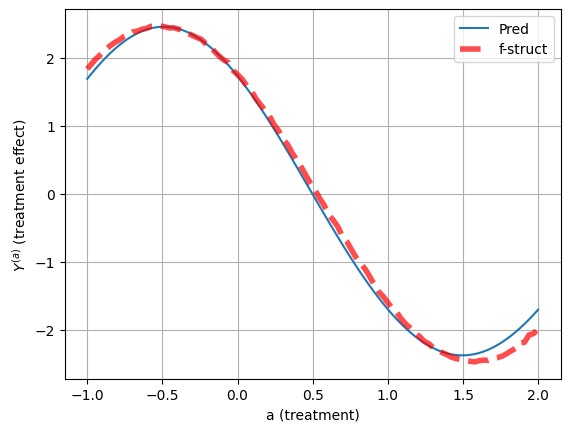

Structured function test set MSE: 0.012173216561064765
Structured function test set MAE: 0.08697379947952304


In [6]:
A_linspace = do_A

f_struct_pred = KernelATE_model.predict(do_A.reshape(-1, 1))

plt.plot(do_A, f_struct_pred, label = "Pred")
plt.plot(A_linspace, EY_do_A, linewidth = 4, color = "red", alpha=0.7, linestyle = "dashed", label = "f-struct")
plt.grid()
plt.xlabel("a (treatment)")
plt.ylabel(r"$Y^{(a)}$ (treatment effect)")
plt.legend()
plt.show()

structured_pred_mse = (np.mean((f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1)) ** 2))
structured_pred_mae = (np.mean(np.abs(f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1))))
print("Structured function test set MSE: {}".format(structured_pred_mse))
print("Structured function test set MAE: {}".format(structured_pred_mae))